Questions to consider later:
- Do images needs to be normalized? 
- Do we need to do any special pre-processing to the text data? 

In [77]:
# pip install pillow 
import json
from pathlib import Path
import pandas as pd 
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter
from tqdm.notebook import tqdm

pd.options.display.max_rows = 5

# Data pre-processing

Assumptions:
- Train, test data only for now, no val data used 

In [31]:
# Images

path_images = Path("data/images")
ids_images = [folder.name for folder in path_images.iterdir() if folder.is_dir()]

len(ids_images), ids_images[:3] 

(2955, ['CXR1000_IM-0003', 'CXR1001_IM-0004', 'CXR1004_IM-0005'])

In [32]:
# Annotations

path_annot = 'data/annotation_quiz_all.json'
with open(path_annot, 'r') as f:
    data = json.load(f)

filtered_data = {k: v for k, v in data.items() if k in ['test', 'train']}

df_train = pd.DataFrame(filtered_data['train'])
df_test  = pd.DataFrame(filtered_data['test'])
df_data  = pd.concat([df_train, df_test], ignore_index=True)

assert len(set(df_data.id)) == len(df_data.id)

df_data = df_data.set_index('id')
df_data

,report,split
id,,
CXR2384_IM-0942,{'bone': 'Degenerative changes are present in ...,train
CXR2926_IM-1328,"{'bone': 'Bony structures are intact.', 'heart...",train
CXR1451_IM-0291,"{'bone': '', 'heart': 'Heart size normal.', 'l...",train
CXR2887_IM-1289,{'bone': 'Displaced fracture of the mid one-th...,train
CXR1647_IM-0424,{'bone': 'Visualized osseous structures of the...,train
...,...,...
CXR1004_IM-0005,{'bone': 'Degenerative changes of the acromioc...,test
CXR226_IM-0851,"{'bone': 'Thoracic spondylosis.', 'heart': 'Th...",test
CXR1708_IM-0466,"{'bone': 'No acute, displaced rib fractures id...",test


In [33]:
ids_annot = df_data.index.to_list()
assert all(item in ids_images for item in ids_annot) 

len(ids_annot), ids_annot[:3] 

(2659, ['CXR2384_IM-0942', 'CXR2926_IM-1328', 'CXR1451_IM-0291'])

In [6]:
# Vast majority of images consists of 2 images. Let's assume we select only the first 2. Ideally, need to generalize this later. 

def count_images_in_folder(folder_path):
    
    count = sum(1 for file in folder_path.iterdir() if file.suffix.lower() in {".jpg", ".jpeg", ".png", ".gif", ".bmp", ".tiff"} )
    return count

images_count = {folder_id: count_images_in_folder(path_images / folder_id) for folder_id in ids_annot}

Counter(images_count.values())

Counter({2: 1966, 3: 99, 4: 4})

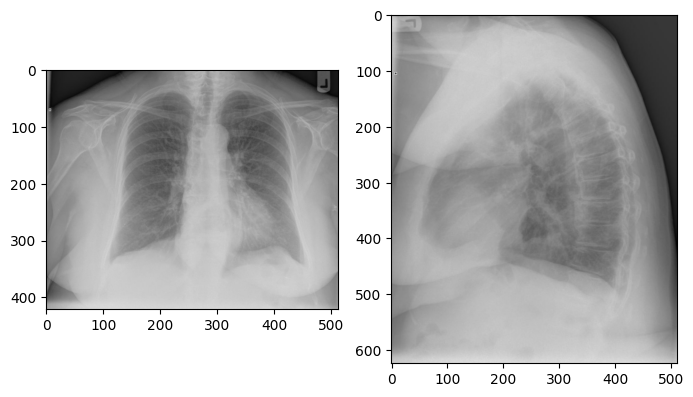

In [75]:
# Plot manually selected id. Images are various sizes. 

fig, axes = plt.subplots(1, 2, figsize=(7, 4))
for ax, image_filename in zip(axes, ["0.png", "1.png"]):
    path_image = path_images / ids_annot[0] / image_filename
    img = Image.open(path_image)
    ax.imshow(img)

plt.tight_layout()

In [36]:
sizes = []

for folder_id in tqdm(ids_annot):
    try:
        img0 = Image.open(path_images / folder_id / "0.png")
        img1 = Image.open(path_images / folder_id / "1.png")

        sizes.append({'id': folder_id,
                      'img0_w': img0.size[0], 'img0_h': img0.size[1],
                      'img1_w': img1.size[0], 'img1_h': img1.size[1] })
    except FileNotFoundError as e:
        print(f"File not found: {e}")

sizes = pd.DataFrame(sizes).set_index('id')  

  0%|          | 0/2659 [00:00<?, ?it/s]

In [37]:
sizes

,img0_w,img0_h,img1_w,img1_h
id,,,,
CXR2384_IM-0942,512,420,512,624
CXR2926_IM-1328,512,512,512,562
CXR1451_IM-0291,512,420,512,624
CXR2887_IM-1289,512,512,512,530
CXR1647_IM-0424,512,624,512,420
...,...,...,...,...
CXR1004_IM-0005,512,512,512,512
CXR226_IM-0851,512,511,512,558
CXR1708_IM-0466,512,420,512,624


In [39]:
# Widths of images 0 and 1 are the same 512. Can concatinate based on the same widths for training/testing

sizes['img0_w'].value_counts(dropna=False), sizes['img1_w'].value_counts(dropna=False) 

(img0_w
 512    2659
 Name: count, dtype: int64,
 img1_w
 512    2659
 Name: count, dtype: int64)

In [56]:
def concatenate_images_vertically(image1, image2, shared_width=512):

    assert shared_width == image1.width == image2.width

    total_height = image1.height + image2.height
    concatenated_image = Image.new('RGB', (shared_width, total_height))
    concatenated_image.paste(image1.crop((0, 0, shared_width, image1.height)), (0, 0))
    concatenated_image.paste(image2.crop((0, 0, shared_width, image2.height)), (0, image1.height))
    return concatenated_image

df_data['image'] = None
for folder_id in tqdm(ids_annot):
    try:
        img0 = Image.open(path_images / folder_id / "0.png")
        img1 = Image.open(path_images / folder_id / "1.png")
        concatenated_image = concatenate_images_vertically(img0, img1)

        df_data.loc[folder_id , 'image'] = concatenated_image 
        
    except FileNotFoundError as e:
        print(f"File not found: {e}")

df_data

  0%|          | 0/2659 [00:00<?, ?it/s]

,report,split,image
id,,,
CXR2384_IM-0942,{'bone': 'Degenerative changes are present in ...,train,<PIL.Image.Image image mode=RGB size=512x1044 ...
CXR2926_IM-1328,"{'bone': 'Bony structures are intact.', 'heart...",train,<PIL.Image.Image image mode=RGB size=512x1074 ...
CXR1451_IM-0291,"{'bone': '', 'heart': 'Heart size normal.', 'l...",train,<PIL.Image.Image image mode=RGB size=512x1044 ...
CXR2887_IM-1289,{'bone': 'Displaced fracture of the mid one-th...,train,<PIL.Image.Image image mode=RGB size=512x1042 ...
CXR1647_IM-0424,{'bone': 'Visualized osseous structures of the...,train,<PIL.Image.Image image mode=RGB size=512x1044 ...
...,...,...,...
CXR1004_IM-0005,{'bone': 'Degenerative changes of the acromioc...,test,<PIL.Image.Image image mode=RGB size=512x1024 ...
CXR226_IM-0851,"{'bone': 'Thoracic spondylosis.', 'heart': 'Th...",test,<PIL.Image.Image image mode=RGB size=512x1069 ...
CXR1708_IM-0466,"{'bone': 'No acute, displaced rib fractures id...",test,<PIL.Image.Image image mode=RGB size=512x1044 ...


In [66]:
# This df is complete withoyt nans
df_data.isnull().any().any() 

np.False_

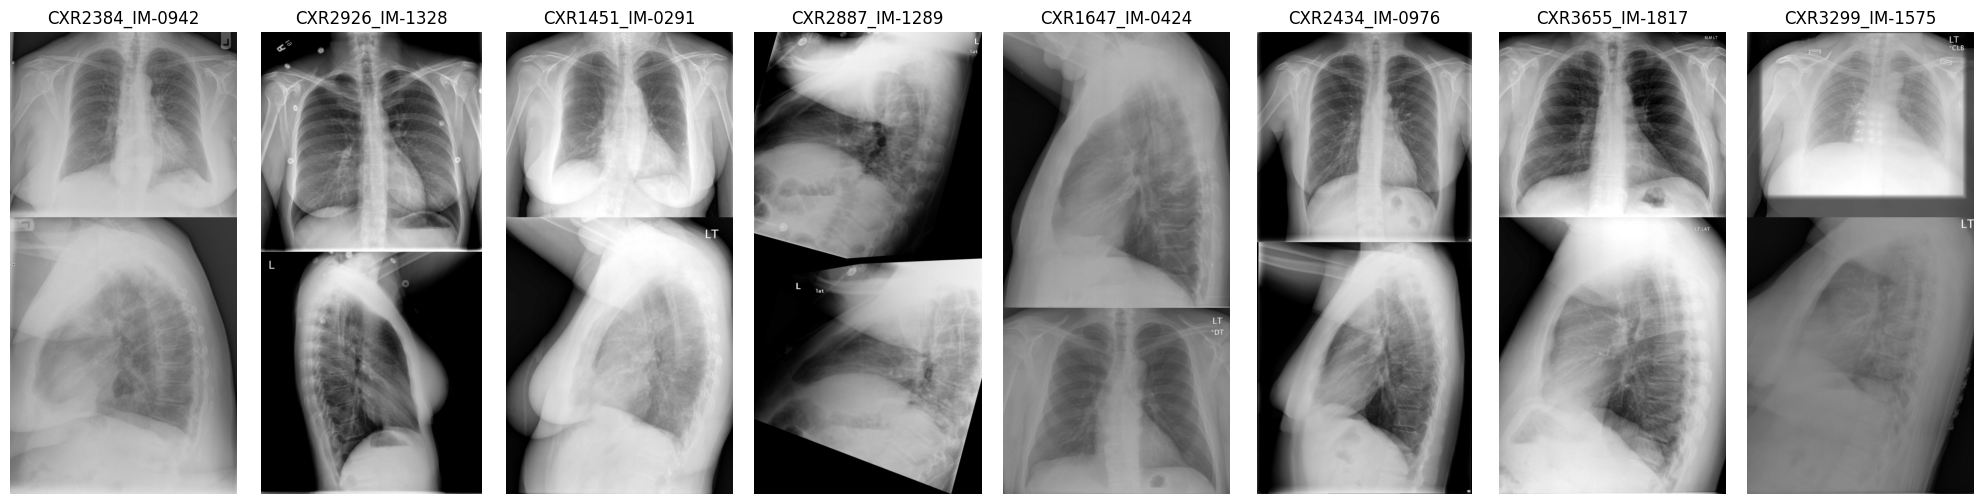

In [76]:
# Plot the first 8 images

fig, axes = plt.subplots(nrows=1, ncols=8, figsize=(20, 5))
for i, (index, row) in enumerate(df_data.iloc[:8, :].iterrows()):

    ax = axes[i]
    ax.imshow(row['image'])
    ax.set_title(index); ax.axis('off')
plt.tight_layout()

- Notice, some images require a special attention, like CXR2887_IM-1289. Because of the time constraint, lets' keep moving for now and not pre-proicess images manually. 
- In some cases, it is first Lateral, then Frontal images are concatinated (CXR1647_IM-0424). I keep it like this for now, but needs to be modified to unify the way we present images for the model to train, and normalized.
- The other issue - is the scale of images. In CV a unified scale ensures that all images fed into the model have the same dimensions, which can help the model learn more effectively by reducing variability that isn't relevant to the task. 


In [91]:
# Quite a lot of fields are empty in the reports, especially the "bone" and "others". Below % 

df_report = df_data['report'].apply(pd.Series).replace(['', ' ', '  '], None)
df_report.isnull().sum(axis=0)*100 / len(df_report)

bone           44.076721
heart           2.068447
lung            0.075216
mediastinal    21.850320
others         65.513351
dtype: float64

In [118]:
instruction_system = """
You are a specialist Radiologist specializing in the analysis of chest X-ray images by looking at them. 
Your goal is to analyze X-ray images and write diagnostic reports based on X-ray images.
You only write reports for five anatomical regions: lung, heart, mediastinal, bone, and others.
Each report may not necessarily include findings for all regions. Some regions might be empty.
"""

instruction_user = """
You are provided with a chest X-ray image.
Write a radiology report accurately by looking at the image provided. 
Each image is the Frontal and Lateral X-ray images concatenated vertically, with no particular order.    
Write the report carefully. Consider each anatomical region separately, but you don't have to write a report for each region. 
"""

def conversations(row):
    
   report_text = " ".join(["%s: %s" % (k, v) for k, v in row['report'].items() if v])    

   conversation = [ {  "role": "system", 
                     "content": [{"type": "text", "text": instruction_system},],},

                  {  "role": "user",
                     "content": [ {"type": "text", "text": instruction_user},
                                    {"type": "image", "image": row["image"]},],},
                  
                  {  "role": "assistant",
                     "content": [{"type": "text", "text": report_text}],},
                  ]
    
   return {"messages": conversation}

In [119]:
data_train = [  conversations(row) for _, row in df_data.loc[df_data['split'] == 'train', :].iterrows()  ]
data_test  = [  conversations(row) for _, row in df_data.loc[df_data['split'] == 'test',  :].iterrows()  ]

data_test[45]

{'messages': [{'role': 'system',
   'content': [{'type': 'text',
     'text': '\nYou are a specialist Radiologist specializing in the analysis of chest X-ray images by looking at them. \nYour goal is to analyze X-ray images and write diagnostic reports based on X-ray images.\nYou only write reports for five anatomical regions: lung, heart, mediastinal, bone, and others.\nEach report may not necessarily include findings for all regions. Some regions might be empty.\n'}]},
  {'role': 'user',
   'content': [{'type': 'text',
     'text': "\nYou are provided with a chest X-ray image.\nWrite a radiology report accurately by looking at the image provided. \nEach image is the Frontal and Lateral X-ray images concatenated vertically, with no particular order.    \nWrite the report carefully. Consider each anatomical region separately, but you don't have to write a report for each region. \n"},
    {'type': 'image',
     'image': <PIL.Image.Image image mode=RGB size=512x1044>}]},
  {'role': 'ass

- Notice, I intentionally keep keys of the report findings for the training/testing purposes - lung, heart, mediastinal, bone, and others
- This is because the more information you provide to the model, the better the training. Especially, when the data is well organized into 4 anatomical categories. 

In [120]:
len(data_train), len(data_test) 

(2069, 590)

# Modelling - Fine-tuning

In [ ]:
# pip install unsloth

from unsloth import FastVisionModel
import torch

model, tokenizer = FastVisionModel.from_pretrained(
        "unsloth/Llama-3.2-11B-Vision-Instruct",
        load_in_4bit = True,
        use_gradient_checkpointing = "unsloth") 

In [ ]:
model = FastVisionModel.get_peft_model(
            model,
            finetune_vision_layers    = True, 
            finetune_language_layers  = True, 
            finetune_attention_modules= True,
            finetune_mlp_modules      = True,
            r = 16,           
            lora_alpha = 16,
            lora_dropout = 0,
            bias = "none",
            random_state = 3443,
            use_rslora = False,
            loftq_config = None )

